# Blood Donation

In [76]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

from pylab import rcParams      
rcParams['figure.figsize'] = 8, 8
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [77]:
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score, roc_curve, auc
from sklearn.cross_validation import train_test_split

In [145]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [78]:
def plot_roc_curve(predictions):
    preds = predictions[:,1]
    fpr, tpr, threshold = roc_curve(yval, preds)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [79]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("BloodDonationSubmissionFormat.csv")

In [80]:
train.head()

Unnamed: 0  Months since Last Donation  Number of Donations  \
0         619                           2                   50   
1         664                           0                   13   
2         441                           1                   16   
3         160                           2                   20   
4         358                           1                   24   

   Total Volume Donated (c.c.)  Months since First Donation  \
0                        12500                           98   
1                         3250                           28   
2                         4000                           35   
3                         5000                           45   
4                         6000                           77   

   Made Donation in March 2007  
0                            1  
1                            1  
2                            1  
3                            1  
4                            0

In [81]:
test.head()

Unnamed: 0  Months since Last Donation  Number of Donations  \
0         659                           2                   12   
1         276                          21                    7   
2         263                           4                    1   
3         303                          11                   11   
4          83                           4                   12   

   Total Volume Donated (c.c.)  Months since First Donation  
0                         3000                           52  
1                         1750                           38  
2                          250                            4  
3                         2750                           38  
4                         3000                           34

In [82]:
train["Test"] = False
test["Test"] = True
data = pd.concat([train, test], ignore_index=True)

In [83]:
data.describe()

Made Donation in March 2007  Months since First Donation  \
count                   576.000000                   776.000000   
mean                      0.239583                    34.417526   
std                       0.427200                    24.450047   
min                       0.000000                     2.000000   
25%                       0.000000                    16.000000   
50%                       0.000000                    28.000000   
75%                       0.000000                    50.000000   
max                       1.000000                    98.000000   

       Months since Last Donation  Number of Donations  \
count                  776.000000           776.000000   
mean                     9.453608             5.557990   
std                      8.030935             5.841939   
min                      0.000000             1.000000   
25%                      3.000000             2.000000   
50%                      7.000000             4.000000   
75%                     14.000000             7.000000   
max                     74.000000            50.000000   

       Total Volume Donated (c.c.)  Unnamed: 0  
count                   776.000000  776.000000  
mean                   1389.497423  374.171392  
std                    1460.484632  215.330133  
min                     250.000000    0.000000  
25%                     500.000000  187.750000  
50%                    1000.000000  375.500000  
75%                    1750.000000  558.250000  
max                   12500.000000  747.000000

In [122]:
def make_submission(predictions):
    to_submit = pd.DataFrame(predictions, index=indecies, columns=["Made Donation in March 2007"])
    return to_submit

In [84]:
def plot_confusion(predictions, title):
    import seaborn as sns
    array = confusion_matrix(yval, predictions)
    df_cm = pd.DataFrame(array)
    plt.figure(figsize = (3,3))
    sns.heatmap(df_cm, annot=True, fmt='g', cbar=False)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.title(title);

In [85]:
def plot_correlations(data, size=(5,5)):
    data = data.drop(["Unnamed: 0", "Made Donation in March 2007", "Test"], axis=1)
    columns = data.columns
    data = data.T
    data = pd.DataFrame(np.corrcoef(data), columns=columns, index=columns)
    plt.figure(figsize=size)
    sns.heatmap(data, annot=True, fmt='g', cbar=False)
    plt.xticks(rotation=45)

In [115]:
def importance(model):
    
    ### возвращает отсортированные по абсолютному значению коэффициенты
    
    coefs = pd.DataFrame(model.coef_.T, index=Xtr.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    return coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

In [114]:
def visualize_coefficients(classifier, feature_names, n_top_features=10):
    
    ### визулизирует влияние факторов на целевую переменную
    
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])

    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");

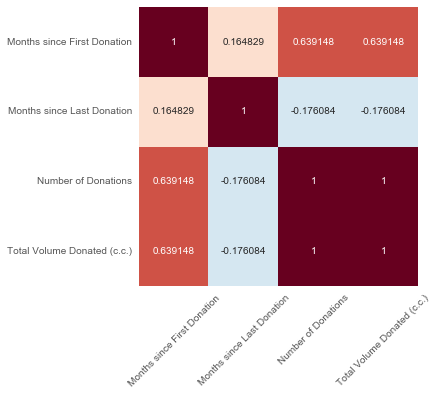

In [86]:
plot_correlations(data)

In [87]:
log_data = (data.drop(["Unnamed: 0", "Made Donation in March 2007", "Test"], axis=1)+1).apply(np.log)
log_data.columns = log_data.columns.map(lambda x: "log "+x)

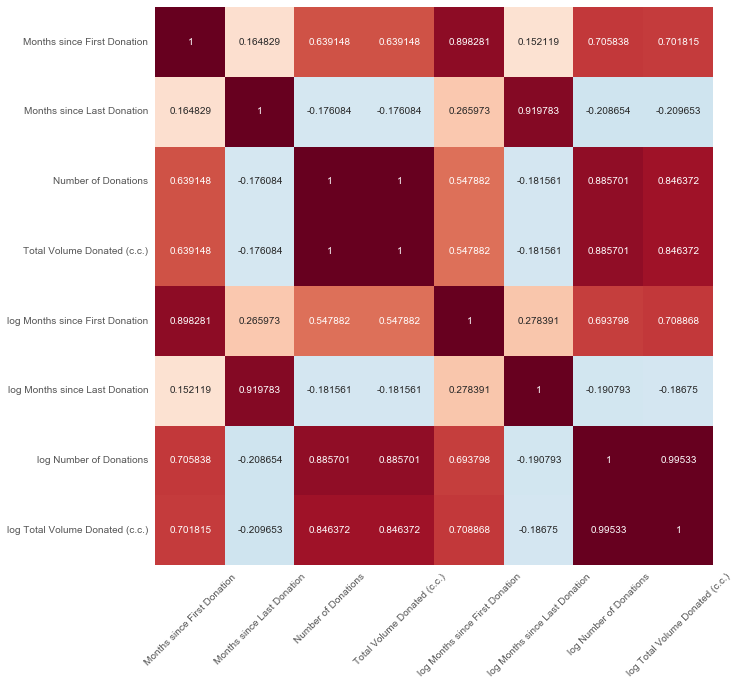

In [88]:
plot_correlations(pd.concat([data, log_data], axis=1), size=(10, 10))

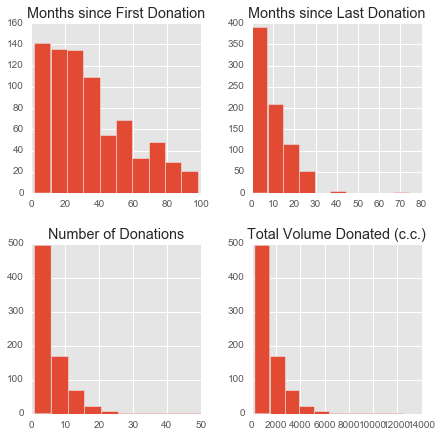

In [89]:
(data.drop(["Unnamed: 0", "Made Donation in March 2007", "Test"], axis=1)).hist(figsize=(7, 7));

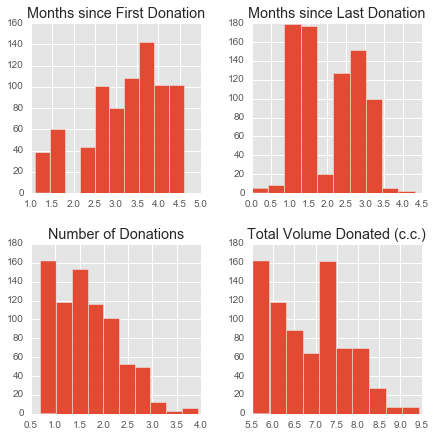

In [90]:
(data.drop(["Unnamed: 0", "Made Donation in March 2007", "Test"], axis=1)+1).apply(np.log).hist(figsize=(7, 7));

In [91]:
y = train['Made Donation in March 2007']
train.drop(['Made Donation in March 2007', 'Unnamed: 0'], axis = 1, inplace=True)
indecies = list(test["Unnamed: 0"])
test.drop(['Unnamed: 0'], axis = 1, inplace=True)

In [128]:
X = pd.concat([data, log_data], axis=1).drop(['Made Donation in March 2007', 'Unnamed: 0'], axis = 1)
#(train+1).apply(np.log)

In [129]:
Xtr, Xval, ytr, yval = train_test_split(X[~X.Test], y, test_size=0.3, random_state=42)

In [103]:
Xtr.shape, Xval.shape

((403, 9), (173, 9))

In [104]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1000, n_jobs=3)
rf.fit(Xtr, ytr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=3, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [105]:
print(log_loss(yval, rf.predict_proba(Xval)))
print(roc_auc_score(yval, rf.predict_proba(Xval)[:,1]))

0.824246928956
0.69840355497


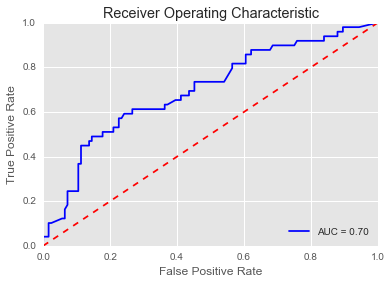

In [106]:
plot_roc_curve(rf.predict_proba(Xval))

In [26]:
from sklearn.calibration import CalibratedClassifierCV
calib = CalibratedClassifierCV(RandomForestClassifier(n_jobs=3, n_estimators=1000), cv=10, method='isotonic')
calib.fit(Xtr, ytr)


CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=3, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
            cv=10, method='isotonic')

In [27]:
print(log_loss(yval, calib.predict_proba(Xval)))
print(roc_auc_score(yval, calib.predict(Xval)))

0.571117572289
0.604674127716


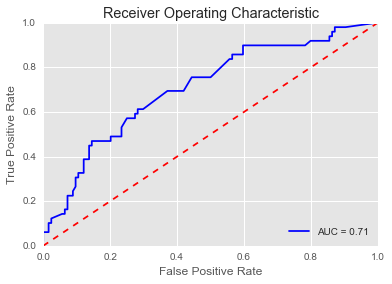

In [29]:
plot_roc_curve(calib.predict_proba(Xval))

In [30]:
import sys
sys.path.append('/Users/dmitrys//xgboost/python-package/')
import xgboost as xgb

In [31]:
dtrain = xgb.DMatrix(X, label=y)

In [32]:
params = {
    'objective': 'binary:logistic',
    'max_depth': 5,
    'eta': 0.001,
    'subsample': 0.5,
    'min_child_weight': 1,
    'colsample_bytree':0.6
}
trees = 200

In [33]:
cv = xgb.cv(params, dtrain, metrics=('auc'), verbose_eval=False, nfold=7, show_stdv=False, num_boost_round=trees)

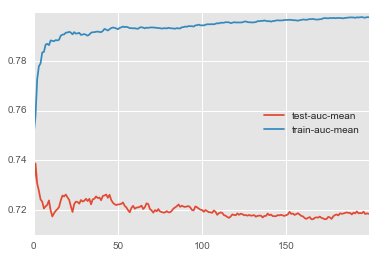

In [34]:
cv.plot(y=['test-auc-mean', 'train-auc-mean'])

In [35]:
cv.loc[cv['test-auc-mean'].argmax()]

test-auc-mean     0.738789
test-auc-std      0.054651
train-auc-mean    0.757923
train-auc-std     0.017633
Name: 1, dtype: float64

In [36]:
cv['test-auc-mean'].argmax()

1

In [37]:
bst = xgb.train(params, dtrain, num_boost_round=75)

In [38]:
imps = pd.Series(bst.get_fscore()).sort_values()

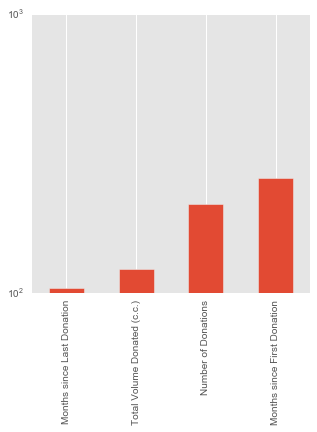

In [39]:
imps.plot(kind='bar', figsize=(5,5),logy=True)

             precision    recall  f1-score   support

          0       0.74      0.98      0.84       124
          1       0.70      0.14      0.24        49

avg / total       0.73      0.74      0.67       173

[[121   3]
 [ 42   7]]


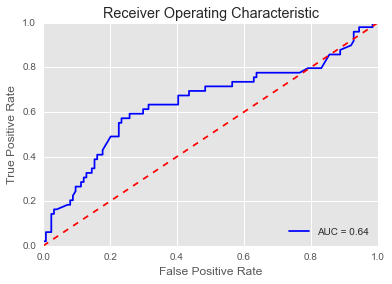

In [107]:
from sklearn import metrics
from sklearn.svm import SVC
# fit a SVM model to the data

model_SVM = SVC(probability=True)
model_SVM.fit(Xtr, ytr)
#print(model_SVM)
# make predictions
expected = yval
predicted = model_SVM.predict(Xval)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
plot_roc_curve(model_SVM.predict_proba(Xval))

GaussianNB(priors=None)
             precision    recall  f1-score   support

          0       0.77      0.89      0.83       124
          1       0.55      0.35      0.42        49

avg / total       0.71      0.73      0.71       173

[[110  14]
 [ 32  17]]


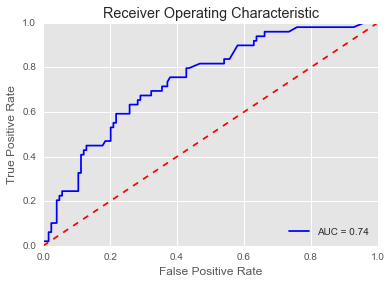

In [116]:
from sklearn.naive_bayes import GaussianNB
model_B = GaussianNB()
model_B.fit(Xtr, ytr)
print(model_B)
# make predictions
expected = yval
predicted = model_B.predict(Xval)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
plot_roc_curve(model_B.predict_proba(Xval))

('Train logloss', 0.45700561728914363)
('Train roc_auc', 0.58117440778644536)
('Validation logloss', 0.50157992424500486)
('Validation roc_auc', 0.56953587886767609)


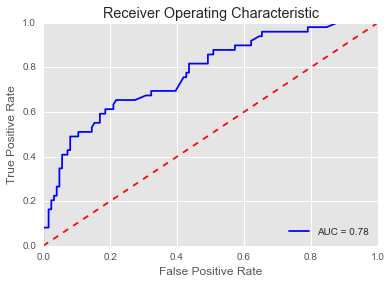

In [117]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(Xtr, ytr)

print('Train logloss', log_loss(ytr, lr.predict_proba(Xtr)))
print('Train roc_auc', roc_auc_score(ytr, lr.predict(Xtr)))
print('Validation logloss', log_loss(yval, lr.predict_proba(Xval)))
print('Validation roc_auc', roc_auc_score(yval, lr.predict(Xval)))
plot_roc_curve(lr.predict_proba(Xval))

In [146]:
pipeline = make_pipeline(StandardScaler(), LogisticRegression())
pipeline.fit(Xtr, ytr)

Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

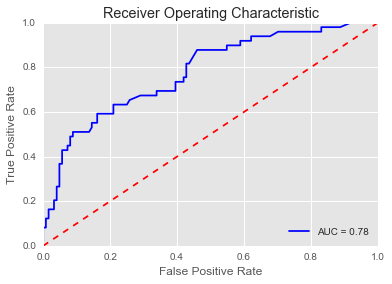

In [147]:
plot_roc_curve(pipeline.predict_proba(Xval))

In [150]:
pipeline.named_steps["logisticregression"]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [148]:
importance(lr)*100

AttributeError: 'Pipeline' object has no attribute 'coef_'

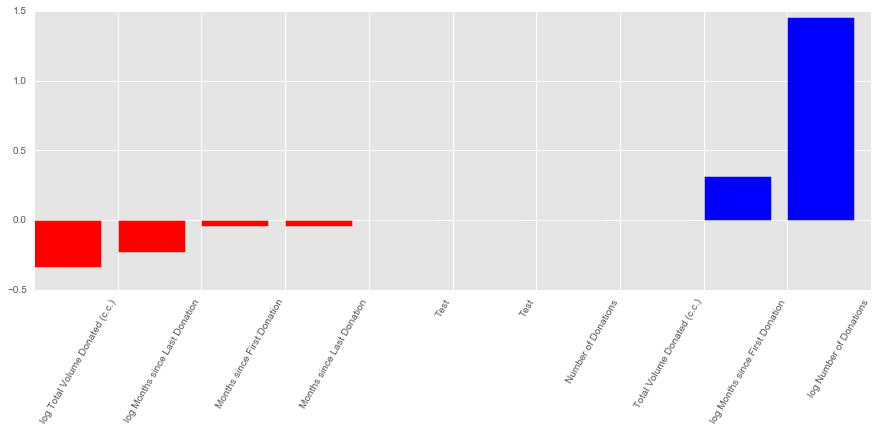

In [121]:
visualize_coefficients(lr, feature_names=Xtr.columns, n_top_features=5)

In [110]:
from sklearn.grid_search import GridSearchCV
Cs = 10**np.linspace(-5, 7, num=30)
grid = {'C': Cs}
gridsearch = GridSearchCV(LogisticRegression(), grid, scoring='neg_log_loss', cv=6)
%time gridsearch.fit(X, y)

CPU times: user 1.52 s, sys: 10.3 ms, total: 1.53 s
Wall time: 1.6 s


GridSearchCV(cv=6, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-05,   2.59294e-05,   6.72336e-05,   1.74333e-04,
         4.52035e-04,   1.17210e-03,   3.03920e-03,   7.88046e-03,
         2.04336e-02,   5.29832e-02,   1.37382e-01,   3.56225e-01,
         9.23671e-01,   2.39503e+00,   6.21017e+00,   1.61026e+01,
         4.1753...    8.53168e+04,   2.21222e+05,   5.73615e+05,   1.48735e+06,
         3.85662e+06,   1.00000e+07])},
       pre_dispatch='2*n_jobs', refit=True, scoring='neg_log_loss',
       verbose=0)

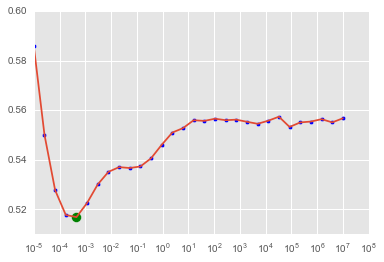

In [111]:
scores = [-x.mean_validation_score for x in  gridsearch.grid_scores_]
plt.plot(Cs, scores)
plt.scatter(Cs, scores)
plt.scatter(Cs[np.argmin(scores)], scores[np.argmin(scores)], c='g', s=100)
plt.xscale('log')

In [112]:
C = Cs[np.argmin(scores)]
C

0.00045203536563602405

('Train logloss', 0.48589131187930235)
('Train roc_auc', 0.52977170256924067)
('Validation logloss', 0.5204702992783079)
('Validation roc_auc', 0.52040816326530615)


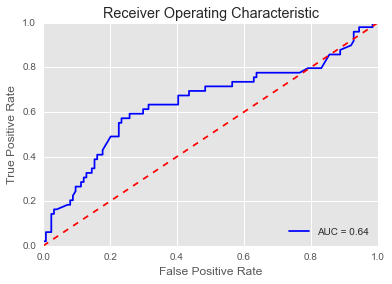

In [113]:
lr = LogisticRegression(C=C)
lr.fit(Xtr, ytr)
print('Train logloss', log_loss(ytr, lr.predict_proba(Xtr)))
print('Train roc_auc', roc_auc_score(ytr, lr.predict(Xtr)))
print('Validation logloss', log_loss(yval, lr.predict_proba(Xval)))
print('Validation roc_auc', roc_auc_score(yval, lr.predict(Xval)))
plot_roc_curve(model_SVM.predict_proba(Xval))

In [56]:
xgb_prediction = bst.predict(xgb.DMatrix(test))

In [131]:
Xtr.shape

(403, 9)

In [132]:
X.shape

(776, 9)

In [135]:
to_submit = make_submission(lr.predict_proba(X[X.Test])[:,1])

In [141]:
to_submit.to_csv('/Users/dmitrys/Desktop/DataProjects/DrivenData/BloodDonations/submission.csv')

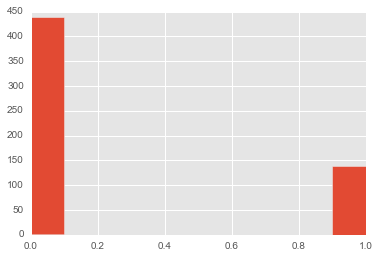

In [136]:
y.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11bf3ee90>]], dtype=object)

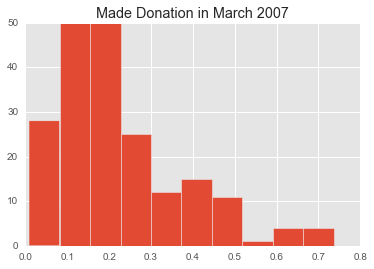

In [137]:
to_submit.hist()